In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Some incorporated code and references:
https://www.kaggle.com/code/hansamaheshwari/twitter-sentiment-analysis-lr-hansa


# Part 1
## Data Pre-Processing

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df.head()

ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1

For part 2 you will need to load the text pre-processing code from here 


In [3]:
# Lower case all the text
def lowercase(tweet):
    return tweet.lower()

#Remove tags
def remove_tags(tweet):
    return re.sub("@[A-Za-z0-9_]+", '', str(tweet))

#Remove mentions
def remove_mentions(tweet):
    return re.sub("#[A-Za-z0-9_]+", '', str(tweet))

# Remove all URLs
def remove_url(tweet):
    urls = re.compile(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+')
    return re.sub(urls, ' ', str(tweet))

#Token nize the string
def tokenize(tweet):
    tok_tweet = nltk.tokenize.word_tokenize(tweet)
    return ' '.join(tok_tweet)

#Remove rt in front of the string if starts with rt is detected
def remove_rt (tweet):
    x = re.search("^rt",tweet)
    if x:
        temp = re.sub("rt", '', str(tweet))
    else:
        temp = tweet
    return temp

#Remove stopwords
def remove_stopwords(tweet):
    words = tweet.split()
    clean_tweet = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(clean_tweet)

#remove non alphabatical numbers
def remove_nonAlphaNum(tweet):
    return re.sub(r"[^\w\s']+", '', tweet)

In [4]:
def clean(tweet):
    tweet = lowercase(tweet) 
    tweet = remove_tags(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_url(tweet)
    tweet = tokenize(tweet)
    tweet = remove_rt(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_nonAlphaNum(tweet)
    return tweet


And stop here

In [ ]:
#Treat the raw string
df['Cleaned'] = df['text'].apply(clean)

#Delete ID column as it is not relevant
df.drop('ID',axis = 1)

text  label  \
0       Josh Jenkins is looking forward to TAB Breeder...      1   
1       RT @MianUsmanJaved: Congratulations Pakistan o...      1   
2       RT @PEPalerts: This September, @YESmag is taki...      1   
3       RT @david_gaibis: Newly painted walls, thanks ...      1   
4       RT @CedricFeschotte: Excited to announce: as o...      1   
...                                                   ...    ...   
550386  @goddesses_o I can't stop watching her...mm. M...      0   
550387  Poor old Tom Odell doesn't look like he would ...      0   
550388  #antsmasher I smashed  7 ants in this awesome ...      1   
550389  @LizHudston @KymWyllie @Evasmiless @meanBok @l...      1   
550390  Bixbeat Mixtape Vol.2 is here with great artis...      1   

                                                  Cleaned  
0       josh jenkins looking forward tab breeders crow...  
1          congratulations pakistan becoming world odds    
2        september  taking maine mendoza  surprise tha...  
3        newly painted walls  thanks million custodial...  
4        excited announce  july 2017 feschotte lab rel...  
...                                                   ...  
550386                            ca n't stop watching     
550387  poor old tom odell n't look like would know wr...  
550388              smashed 7 ants awesome game    hjfjfi  
550389                            morning girls wonderful  
550390  bixbeat mixtape vol2 great artiste join moveme...  

[550391 rows x 3 columns]

The cleaned csv file can be found here:https://utoronto-my.sharepoint.com/:x:/g/personal/yew_wang_mail_utoronto_ca/EdUeyO2A3alKlxrj8RxRMvMBqZKkc1bv6cghXCc68Jtwdg?e=uYOgCA

In [5]:
#Save cleaned dataset to csv and load in later step to save processing time
# df.to_csv('/cleaned_sentiment_analysis.csv', index=False)
cleaned_df = pd.read_csv('cleaned_sentiment_analysis.csv')
# cleaned_df = df.drop('text', axis = 1)

In [6]:
cleaned_df.dropna(inplace=True)

In [7]:
#Split the dataset into train-test and apply the TFIDF vectorization on training dataset
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['Cleaned'], cleaned_df['label'], test_size=0.3, random_state=42)
# apply tf-idf and get the top 200 features
tfidf = TfidfVectorizer(lowercase=True, max_features = 200)
X_train_idf = tfidf.fit_transform(X_train) # only fit the training data    
X_test_idf = tfidf.transform(X_test)

In [8]:
X_train_idf = pd.DataFrame(X_train_idf.todense(), columns = tfidf.get_feature_names_out())
X_test_idf = pd.DataFrame(X_test_idf.todense(), columns = tfidf.get_feature_names_out())
X_train_idf.head(10)

10  2016  also  always  amazing  amp   another  ass  awesome  baby  ...  \
0  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
1  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
2  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
3  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
4  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
5  0.0   0.0   0.0     0.0      0.0  0.0  0.594781  0.0      0.0   0.0  ...   
6  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
7  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
8  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   
9  0.0   0.0   0.0     0.0      0.0  0.0  0.000000  0.0      0.0   0.0  ...   

   winter  wish  wonderful  work  world  would  wow  yall  year  years  
0     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
1     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
2     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
3     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
4     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
5     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
6     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
7     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
8     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  
9     0.0   0.0        0.0   0.0    0.0    0.0  0.0   0.0   0.0    0.0  

[10 rows x 200 columns]

In [ ]:
def plot_roc_curve(y_true, y_score):
    # Compute false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Compute area under the ROC curve
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 8))
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression

In [ ]:
clf = LogisticRegression().fit(X_train_idf, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train_idf)
y_test_predict = clf.predict(X_test_idf)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(train_accuracy, test_accuracy)

0.8778398693913148 0.8782385930062138


With gridsearchCV and Cross-Validation

In [ ]:
#All the gridsearch cells should only be run once
'''
parameters = {'C':[0.01, 0.1, 1, 10, 100], 
              'solver':('liblinear','lbfgs', 'newton-cg'),
              'penalty':('none',  'l2')}

model = LogisticRegression()
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('Best cross-validation score is :\n',cv.best_score_)
print('Best parameter:\n', cv.best_params_)
'''

"\nparameters = {'C':[0.01, 0.1, 1, 10, 100], \n              'solver':('liblinear','lbfgs', 'newton-cg'),\n              'penalty':('none',  'l2')}\n\nmodel = LogisticRegression()\ncv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)\ncv.fit(X_train_idf, y_train)\n\nprint('Best cross-validation score is :\n',cv.best_score_)\nprint('Best parameter:\n', cv.best_params_)\n"

In [ ]:
# {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'} was determined to be the best hyperparameter set
bestLOGmodel = LogisticRegression(C = 10, penalty= 'l2', solver = 'newton-cg')
bestLOGmodel.fit(X_train_idf, y_train)
y_pred_LOG = bestLOGmodel.predict(X_test_idf)
LOG_f1 = f1_score(y_test, y_pred_LOG)
LOG_acc = accuracy_score(y_test, y_pred_LOG)
print("F1 Score Logistic Regression:",LOG_f1)
print("Accuracy Score Logistic Regression:",LOG_acc)

F1 Score Logistic Regression: 0.906256559521977
Accuracy Score Logistic Regression: 0.8782870432054651


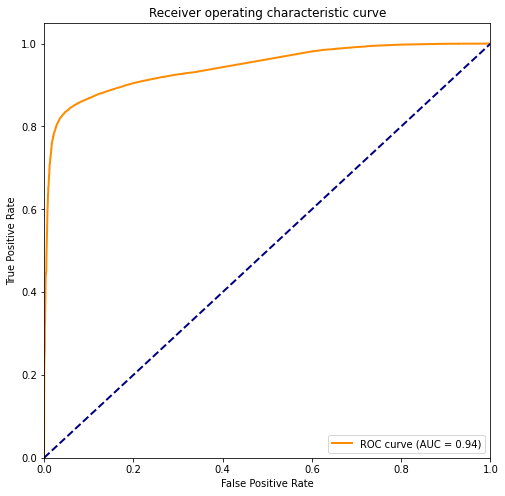

In [ ]:
y_test_prob_LOG = bestLOGmodel.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_LOG[:, 1])

## Naive Bayes

In [ ]:
clf = BernoulliNB().fit(X_train_idf, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train_idf)
y_test_predict = clf.predict(X_test_idf)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)
test_f1 = f1_score(y_test, y_test_predict)
print("F1 Score NB:",test_f1)
print("Accuracy Score NB:",test_accuracy)

F1 Score NB: 0.9023535210683669
Accuracy Score NB: 0.8716251408083916


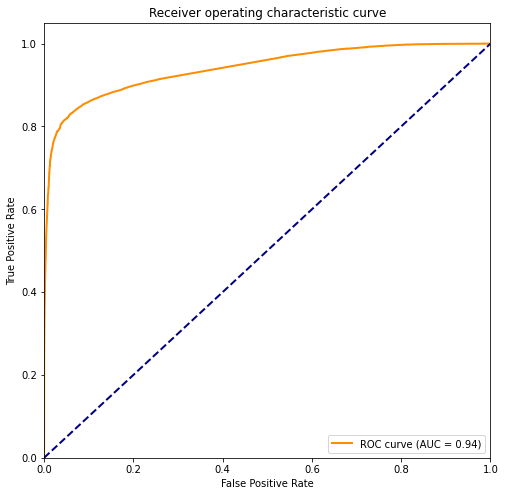

In [ ]:
y_test_prob_NB = clf.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_NB[:, 1])

### SVM

With gridsearchCV and Cross-Validation

In [ ]:
#All the gridsearch cells should only be run once
'''
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
model = LinearSVC(random_state=0, tol=1e-5)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)
'''

"\nparameters = {'C':[0.001, 0.01, 0.1, 1, 10]}\nmodel = LinearSVC(random_state=0, tol=1e-5)\ncv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)\ncv.fit(X_train_idf, y_train)\n\nprint('The best cross-validation score: ',cv.best_score_)\nprint('The best parameter:', cv.best_params_)\n"

In [ ]:
#C = 1 was the best hyper parameter
bestSVMmodel = LinearSVC(random_state=0, tol=1e-5, C = 1)
bestSVMmodel.fit(X_train_idf, y_train)
y_pred_SVM = bestSVMmodel.predict(X_test_idf)
SVM_f1 = f1_score(y_test, y_pred_SVM)
SVM_acc = accuracy_score(y_test, y_pred_SVM)
print("F1 Score SVM:",SVM_f1)
print("Accuracy Score SVM:",SVM_acc)


F1 Score SVM: 0.9060523094461629
Accuracy Score SVM: 0.8782204241814945


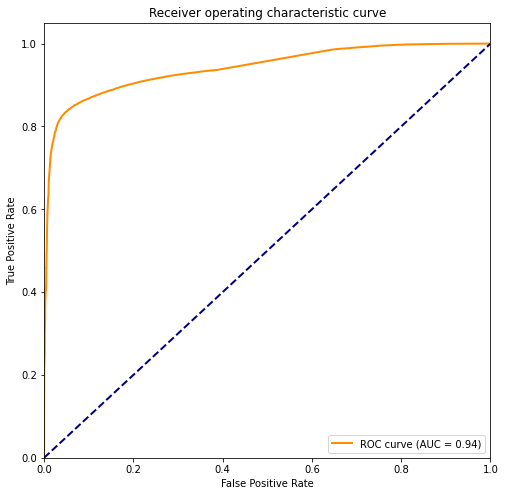

In [ ]:
y_test_prob_SVM = bestSVMmodel._predict_proba_lr(X_test_idf)
plot_roc_curve(y_test, y_test_prob_SVM[:, 1])

### Random Forest

In [ ]:
'''
parameters = {'min_samples_split':[ 10, 15, 20],
              'n_estimators':[50, 100, 200]}

model = RandomForestClassifier( random_state=0)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)
'''

"\nparameters = {'min_samples_split':[ 10, 15, 20],\n              'n_estimators':[50, 100, 200]}\n\nmodel = RandomForestClassifier( random_state=0)\ncv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)\ncv.fit(X_train_idf, y_train)\n\nprint('The best cross-validation score: ',cv.best_score_)\nprint('The best parameter:', cv.best_params_)\n"

Get accuracy and f1 socre on test set

In [ ]:
#Using min sample split = 20 and n estimators = 200
bestRFmodel = RandomForestClassifier(min_samples_split = 20, n_estimators= 200, random_state=0)
bestRFmodel.fit(X_train_idf, y_train)
y_pred_RF = bestRFmodel.predict(X_test_idf)
RF_f1 = f1_score(y_test, y_pred_RF)
RF_acc = accuracy_score(y_test, y_pred_RF)
print("F1 Score Random Forest:",RF_f1)
print("Accuracy Score Random Forest:",RF_acc)


F1 Score Random Forest: 0.9103558479422867
Accuracy Score Random Forest: 0.8838043096452234


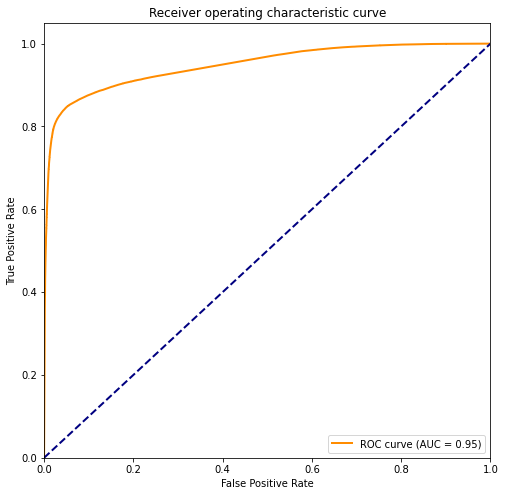

In [ ]:
y_test_prob_RF = bestRFmodel.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_RF[:, 1])

Result Summary for part1

In [ ]:
model_list = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest']
f1_list = [LOG_f1, test_f1, SVM_f1, RF_f1]
acc_list = [LOG_acc, test_accuracy,SVM_acc, RF_acc]


In [ ]:
result_df = pd.DataFrame({
    'Model': model_list,
    'F1 Score': f1_list,
    'Accuracy': acc_list
})
result_df

Model  F1 Score  Accuracy
0  Logistic Regression  0.906257  0.878287
1          Naive Bayes  0.902354  0.871625
2                  SVM  0.906052  0.878220
3        Random Forest  0.910356  0.883804

Based on F1 socre, Random Forest model with min_sample_split = 20, and 200 n_estimators performed the best, this model will be used in part 2.

# Part 2

In this part, our group will use newsAPI to collect the descriptions of news articles involve keywords: "russia", "ukraine", and "war". Then use the trained model from part 1 to perform Sentiment_Analysis on news descriptions to evaluate if it will be labeled as positive or negative.

In [ ]:
!pip install newsapi-python
import pandas as pd
from newsapi import NewsApiClient
from collections import Counter
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*To save the api usage, the following cell should **only** be called when the sources or date needs to be modified. *

In [ ]:
# Initialize NewsAPI client
newsapi = NewsApiClient(api_key='4678da4b69ee46599f1280355d700b2e')

# Set query parameters
query = 'russia AND ukraine AND war' #keywords
language = 'en'
today = datetime.date.today()
from_date = (today - datetime.timedelta(days=25)).isoformat()

aggregated_list = []
list_of_news_sources = ['bbc-news','the-verge', 'abc-news','associated-press', 'bloomberg', 'business-insider', 'cbs-news', 'cnn',
                        'fortune','fox-news','google-news','msnbc','politico', 'reuters','the-wall-street-journal','the-washington-post','time','usa-today','wired']
# Retrieve articles
for src in list_of_news_sources:
  articles = newsapi.get_everything(q=query,
                                    sources=src,
                                    language=language,
                                    from_param=from_date,
                                    sort_by='relevancy')

  # Extract description text from articles
  descriptions = [article['description'] for article in articles['articles']]
  aggregated_list.extend(descriptions)

news_df = pd.DataFrame({
    'description': aggregated_list,

})
news_df['description'] = news_df['description'].astype(str)
news_df


The pre-processed news data should be loaded here in this step:

In [9]:
#news_df.to_csv('/news_description.csv', index=False)
news_df = pd.read_csv('news_description.csv')

In [10]:
#Treat the raw string
news_df['Cleaned'] = news_df['description'].apply(clean)


In [11]:
news_df

description  \
0     The Russian ambassador said he wanted the UN t...   
1     Steve Rosenberg looks at why Vladimir Putin se...   
2     Both Ukraine and Russia have reported inflicti...   
3     Russia and China refused to condemn Moscow's i...   
4     The resolution is approved by 141 countries, w...   
...                                                 ...   
1282  Since Russia’s full-scale assault began, Ukrai...   
1283  Plus: The US Marshals disclose a “major” cyber...   
1284  Clearview AI is being used by the Ukrainian go...   
1285  Digital traces including social posts and sear...   
1286  A new State Department proposal asks other nat...   

                                                Cleaned  
0     russian ambassador said wanted un commemorate ...  
1     steve rosenberg looks vladimir putin set sail ...  
2     ukraine russia reported inflicting significant...  
3     russia china refused condemn moscow 's invasio...  
4     resolution approved 141 countries  seven  incl...  
...                                                 ...  
1282  since russia  fullscale assault began  ukraine...  
1283  plus  us marshals disclose  major  cybersecuri...  
1284  clearview ai used ukrainian government identif...  
1285  digital traces including social posts search q...  
1286  new state department proposal asks nations agr...  

[1287 rows x 2 columns]

In [12]:
#Load another elon twitter reply dataset
elon_reply_df = pd.read_csv('tw_reply.csv')

In [13]:
#Treat the raw string
elon_reply_df['cleaned'] = elon_reply_df['text'].apply(clean)

In [14]:
elon_reply_df

created_at  \
0       2022-10-06T23:58:47.000Z   
1       2022-10-06T23:57:17.000Z   
2       2022-10-06T23:57:11.000Z   
3       2022-10-06T23:56:25.000Z   
4       2022-10-06T23:53:49.000Z   
...                          ...   
336900  2022-10-03T16:42:28.000Z   
336901  2022-10-03T16:42:24.000Z   
336902  2022-10-03T16:41:58.000Z   
336903  2022-10-03T16:41:34.000Z   
336904  2022-10-03T16:41:31.000Z   

                                                     text  \
0       @elonmusk This is truly foolish, Elon. Your ow...   
1                                 @elonmusk Stop the war!   
2       @elonmusk After Einstein became famous, report...   
3       @elonmusk That’s Ukrainian business. Not yours...   
4       @elonmusk your position is phenomenal\n\nthe o...   
...                                                   ...   
336900  @elonmusk @AkiKivirinta Didn’t they already ha...   
336901  @elonmusk @AkiKivirinta You’re exactly they ty...   
336902  @elonmusk @AkiKivirinta all of Ukraine are Ukr...   
336903  @elonmusk @AkiKivirinta Dragon. @elonmusk @Spa...   
336904     @elonmusk #Good Monday https://t.co/PGgL2rDd0U   

        in_reply_to_tweet_id  retweet_count  reply_count  like_count  \
0        1576994262226702336              0            0           0   
1        1576994262226702336              0            0           0   
2        1576994262226702336              1            3          13   
3        1576994262226702336              0            0           0   
4        1576994262226702336              1            0           0   
...                      ...            ...          ...         ...   
336900   1576975654779617289              0            9          18   
336901   1576975654779617289              1            9          67   
336902   1576975654779617289             17           13        1001   
336903   1576975654779617289              1            0           3   
336904   1576975654779617289              0            0           0   

                                                  cleaned  
0       truly foolish  elon  life experience taught be...  
1                                               stop war   
2       einstein became famous  reporters started inte...  
3        ukrainian business  russia  disagree imperial...  
4       position phenomenal opinion western world issu...  
...                                                   ...  
336900                       already  referendum  though   
336901        exactly type person would caved hitler 30    
336902                   ukraine ukraine  crimea ukraine   
336903                                            dragon   
336904                                             monday  

[336905 rows x 7 columns]

Fit the cleaned news data on the best model part 1 trained (Random Forest)

In [15]:
X_news_data = tfidf.fit_transform(news_df['Cleaned']) # fit-transform the vectorizer

In [ ]:

y_pred_RF_news = bestRFmodel.predict(X_news_data)


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
def pie_plot(label):
  plt.figure(figsize=(8, 8))
  # count the number of positive and negative labels
  pos_count = np.count_nonzero(label)
  neg_count = len(label) - pos_count

  # calculate the percentages of positive and negative labels
  pos_percent = pos_count / len(label) * 100
  neg_percent = neg_count / len(label) * 100

  # create a pie chart
  fig, ax = plt.subplots()
  ax.pie([pos_percent, neg_percent], labels=['Positive', 'Negative'], autopct='%1.1f%%')
  ax.axis('equal')  # equal aspect ratio ensures that the pie is drawn as a circle
  ax.set_title('Percentage of Positive and Negative Labels')

  plt.show()

<Figure size 576x576 with 0 Axes>

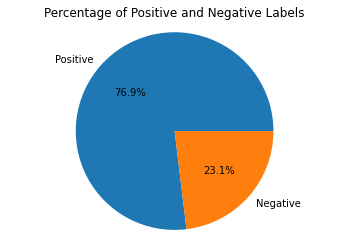

In [ ]:
pie_plot(y_pred_RF_news)

Fit the cleaned news data on the NLTK pre-trained sentiment model to compare the result with our own model in part 1

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def add_sentiment_score(df, text_col):
    # create an instance of the SentimentIntensityAnalyzer class
    analyzer = SentimentIntensityAnalyzer()

    # loop through each row of the dataframe and calculate the compound sentiment score
    scores = []
    for i, row in df.iterrows():
        text = row[text_col]
        score = analyzer.polarity_scores(text)['compound']
        scores.append(score)

    # create a new column in the dataframe based on the compound sentiment score
    df['score'] = [1 if score > 0.5 else 0 for score in scores]

    return df




In [ ]:
add_sentiment_score(news_df, 'Cleaned')

description  \
0     The Russian ambassador said he wanted the UN t...   
1     Steve Rosenberg looks at why Vladimir Putin se...   
2     Both Ukraine and Russia have reported inflicti...   
3     Russia and China refused to condemn Moscow's i...   
4     The resolution is approved by 141 countries, w...   
...                                                 ...   
1282  Since Russia’s full-scale assault began, Ukrai...   
1283  Plus: The US Marshals disclose a “major” cyber...   
1284  Clearview AI is being used by the Ukrainian go...   
1285  Digital traces including social posts and sear...   
1286  A new State Department proposal asks other nat...   

                                                Cleaned  score  
0     russian ambassador said wanted un commemorate ...      0  
1     steve rosenberg looks vladimir putin set sail ...      0  
2     ukraine russia reported inflicting significant...      0  
3     russia china refused condemn moscow 's invasio...      0  
4     resolution approved 141 countries  seven  incl...      0  
...                                                 ...    ...  
1282  since russia  fullscale assault began  ukraine...      0  
1283  plus  us marshals disclose  major  cybersecuri...      0  
1284  clearview ai used ukrainian government identif...      0  
1285  digital traces including social posts search q...      0  
1286  new state department proposal asks nations agr...      0  

[1287 rows x 3 columns]

<Figure size 576x576 with 0 Axes>

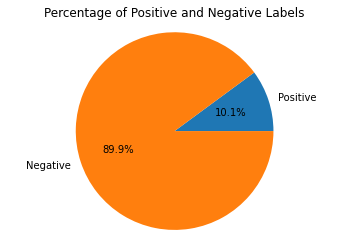

In [ ]:
pie_plot(news_df['score'])

Experiment the the pre-trained NLTK model and part 1 model's performance on another twitter reply dataset

In [ ]:
X_elon_data = tfidf.fit_transform(elon_reply_df['cleaned']) # fit-transform the vectorizer

In [ ]:
y_pred_RF_elon = bestRFmodel.predict(X_elon_data)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<Figure size 576x576 with 0 Axes>

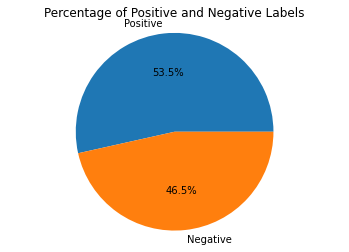

In [ ]:
pie_plot(y_pred_RF_elon)

<Figure size 576x576 with 0 Axes>

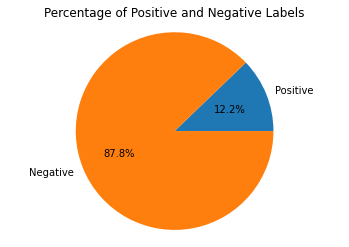

In [ ]:
add_sentiment_score(elon_reply_df, 'cleaned')
pie_plot(elon_reply_df['score'])

### Comparison with pre-trained model Vader (Python library):

Vader is chosen as a comparison to our model as it was designed to detect sentiments expressed in social media, such as Twitter, Facebook. 


Reference: https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399

https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6

In [ ]:
#install vaderSentimentlibrary
!pip install vaderSentiment

#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.8 MB/s eta 0:00:00


In [ ]:
negative, neutral, positive, compound, overall_sentiment = sentiment_vader(news_df['Cleaned'])

In [ ]:
overall_sentiment

'Negative'

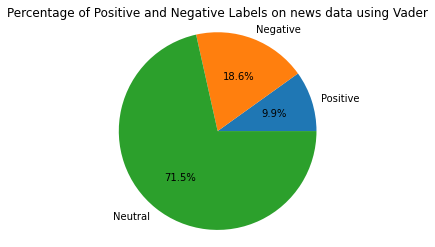

In [ ]:
# create a pie chart
fig, ax = plt.subplots()
ax.pie([positive, negative, neutral], labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%')
ax.axis('equal')  # equal aspect ratio ensures that the pie is drawn as a circle
ax.set_title('Percentage of Positive and Negative Labels on news data using Vader')

plt.show()
     

# Part 3

In [18]:
import pyLDAvis.sklearn
import pyLDAvis
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

news_df_1 =add_sentiment_score(news_df, 'Cleaned')
elon_reply_df_1 = add_sentiment_score(elon_reply_df, 'cleaned')
elon_reply_df_1

created_at  \
0       2022-10-06T23:58:47.000Z   
1       2022-10-06T23:57:17.000Z   
2       2022-10-06T23:57:11.000Z   
3       2022-10-06T23:56:25.000Z   
4       2022-10-06T23:53:49.000Z   
...                          ...   
336900  2022-10-03T16:42:28.000Z   
336901  2022-10-03T16:42:24.000Z   
336902  2022-10-03T16:41:58.000Z   
336903  2022-10-03T16:41:34.000Z   
336904  2022-10-03T16:41:31.000Z   

                                                     text  \
0       @elonmusk This is truly foolish, Elon. Your ow...   
1                                 @elonmusk Stop the war!   
2       @elonmusk After Einstein became famous, report...   
3       @elonmusk That’s Ukrainian business. Not yours...   
4       @elonmusk your position is phenomenal\n\nthe o...   
...                                                   ...   
336900  @elonmusk @AkiKivirinta Didn’t they already ha...   
336901  @elonmusk @AkiKivirinta You’re exactly they ty...   
336902  @elonmusk @AkiKivirinta all of Ukraine are Ukr...   
336903  @elonmusk @AkiKivirinta Dragon. @elonmusk @Spa...   
336904     @elonmusk #Good Monday https://t.co/PGgL2rDd0U   

        in_reply_to_tweet_id  retweet_count  reply_count  like_count  \
0        1576994262226702336              0            0           0   
1        1576994262226702336              0            0           0   
2        1576994262226702336              1            3          13   
3        1576994262226702336              0            0           0   
4        1576994262226702336              1            0           0   
...                      ...            ...          ...         ...   
336900   1576975654779617289              0            9          18   
336901   1576975654779617289              1            9          67   
336902   1576975654779617289             17           13        1001   
336903   1576975654779617289              1            0           3   
336904   1576975654779617289              0            0           0   

                                                  cleaned  score  
0       truly foolish  elon  life experience taught be...      1  
1                                               stop war       0  
2       einstein became famous  reporters started inte...      0  
3        ukrainian business  russia  disagree imperial...      0  
4       position phenomenal opinion western world issu...      0  
...                                                   ...    ...  
336900                       already  referendum  though       0  
336901        exactly type person would caved hitler 30        0  
336902                   ukraine ukraine  crimea ukraine       0  
336903                                            dragon       0  
336904                                             monday      0  

[336905 rows x 8 columns]

In [ ]:
pd.DataFrame(elon_reply_df_1.groupby(['score'])['score'].count()) \
  .rename(columns={"score":"Counts"}) \
  .assign(Percentage=lambda x: (x.Counts/ x.Counts.sum())*100)


Counts  Percentage
score                    
0      295849   87.813775
1       41056   12.186225

In [ ]:
# Average Length & Word Counts of Tweets for elon reply
elon_reply_df_1['text_len'] = elon_reply_df_1['cleaned'].astype(str).apply(len)
elon_reply_df_1['text_word_count'] = elon_reply_df_1['cleaned'].apply(lambda x: len(str(x).split()))
print("Average length of tweets ", round(np.mean(elon_reply_df_1['text_len'])))
print("Average word counts of tweets", round(np.mean(elon_reply_df_1['text_word_count'])))

Average length of tweets  69
Average word counts of tweets 10


In [ ]:
# Top 20 tweets with maximum numbers of retweets
elon_reply_df_1.sort_values('retweet_count', ascending=False)['cleaned'].drop_duplicates().head(20)

206864                                fuck diplomatic reply
334371    russia partial mobilization  go full war mobil...
213084    ukrainerussia peace   ukraine liberates sovere...
83633     let  try  russia leaves ukraine immediately  p...
250191             electoral map 2012 blue prorussia party 
184055      ukrainian saw explorer future  hitec space  ...
215555         highly likely outcome end  question many die
105185    also worth noting possible  albeit unlikely  o...
222598    map ukrainian independence vote 1991 every sin...
199200    elon  man  seems like missed lot history lesso...
73622     trying legitimize pseudoreferendums took place...
202242    elon   cool guy thanks starlink  wonderful car...
54905     mother  killed russian soldiers yard house mar...
328832    fastest way end war fewest deaths support ukra...
272738    praised many acts  good deeds purchase immunit...
75944                                     tezla s new logo 
80814     donbass  relatives  killed rus

In [ ]:
pd.DataFrame(news_df_1.groupby(['score'])['score'].count()) \
  .rename(columns={"score":"Counts"}) \
  .assign(Percentage=lambda x: (x.Counts/ x.Counts.sum())*100)


Counts  Percentage
score                    
0        1157    89.89899
1         130    10.10101

In [ ]:
# Average Length & Word Counts of Tweets
news_df_1['text_len'] = news_df_1['Cleaned'].astype(str).apply(len)
news_df_1['text_word_count'] = news_df_1['Cleaned'].apply(lambda x: len(str(x).split()))
print("Average length of tweets ", round(np.mean(news_df_1['text_len'])))
print("Average word counts of tweets", round(np.mean(news_df_1['text_word_count'])))

Average length of tweets  131
Average word counts of tweets 18


In [ ]:
# Top 10 positive tweets
news_df_1.nlargest(n=10, columns=['score'])["Cleaned"]

27     defence minister hails  great success '' secur...
58     successful initiative aimed ukrainians  us exp...
61     russian tennis player andrey rublev reiterates...
65     ukrainian marta kostyuk wins first wta title a...
68     bellator welterweight champion yaroslav amosov...
79     us president met ukraine 's zelensky surprise ...
96     footage appears show unarmed ukrainian saying ...
97     top us diplomat antony blinken tells russian c...
121    ukraine  first lady offered spirited support n...
125                 's brave move american president  ''
Name: Cleaned, dtype: object

In [ ]:
# Top 10 negative tweets
news_df_1.nsmallest(n=10, columns=['score'])["Cleaned"]

0    russian ambassador said wanted un commemorate ...
1    steve rosenberg looks vladimir putin set sail ...
2    ukraine russia reported inflicting significant...
3    russia china refused condemn moscow 's invasio...
4    resolution approved 141 countries  seven  incl...
5    russia captured mariupol may brutal siege   's...
6    man expected run president said us interest ru...
7    families told leave kupiansk  ukraine recaptur...
8    beijing sees kremlin 's war serving useful geo...
9    residential buildings infrastructure among hit...
Name: Cleaned, dtype: object

In [59]:

from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *

#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Negative Sentiments


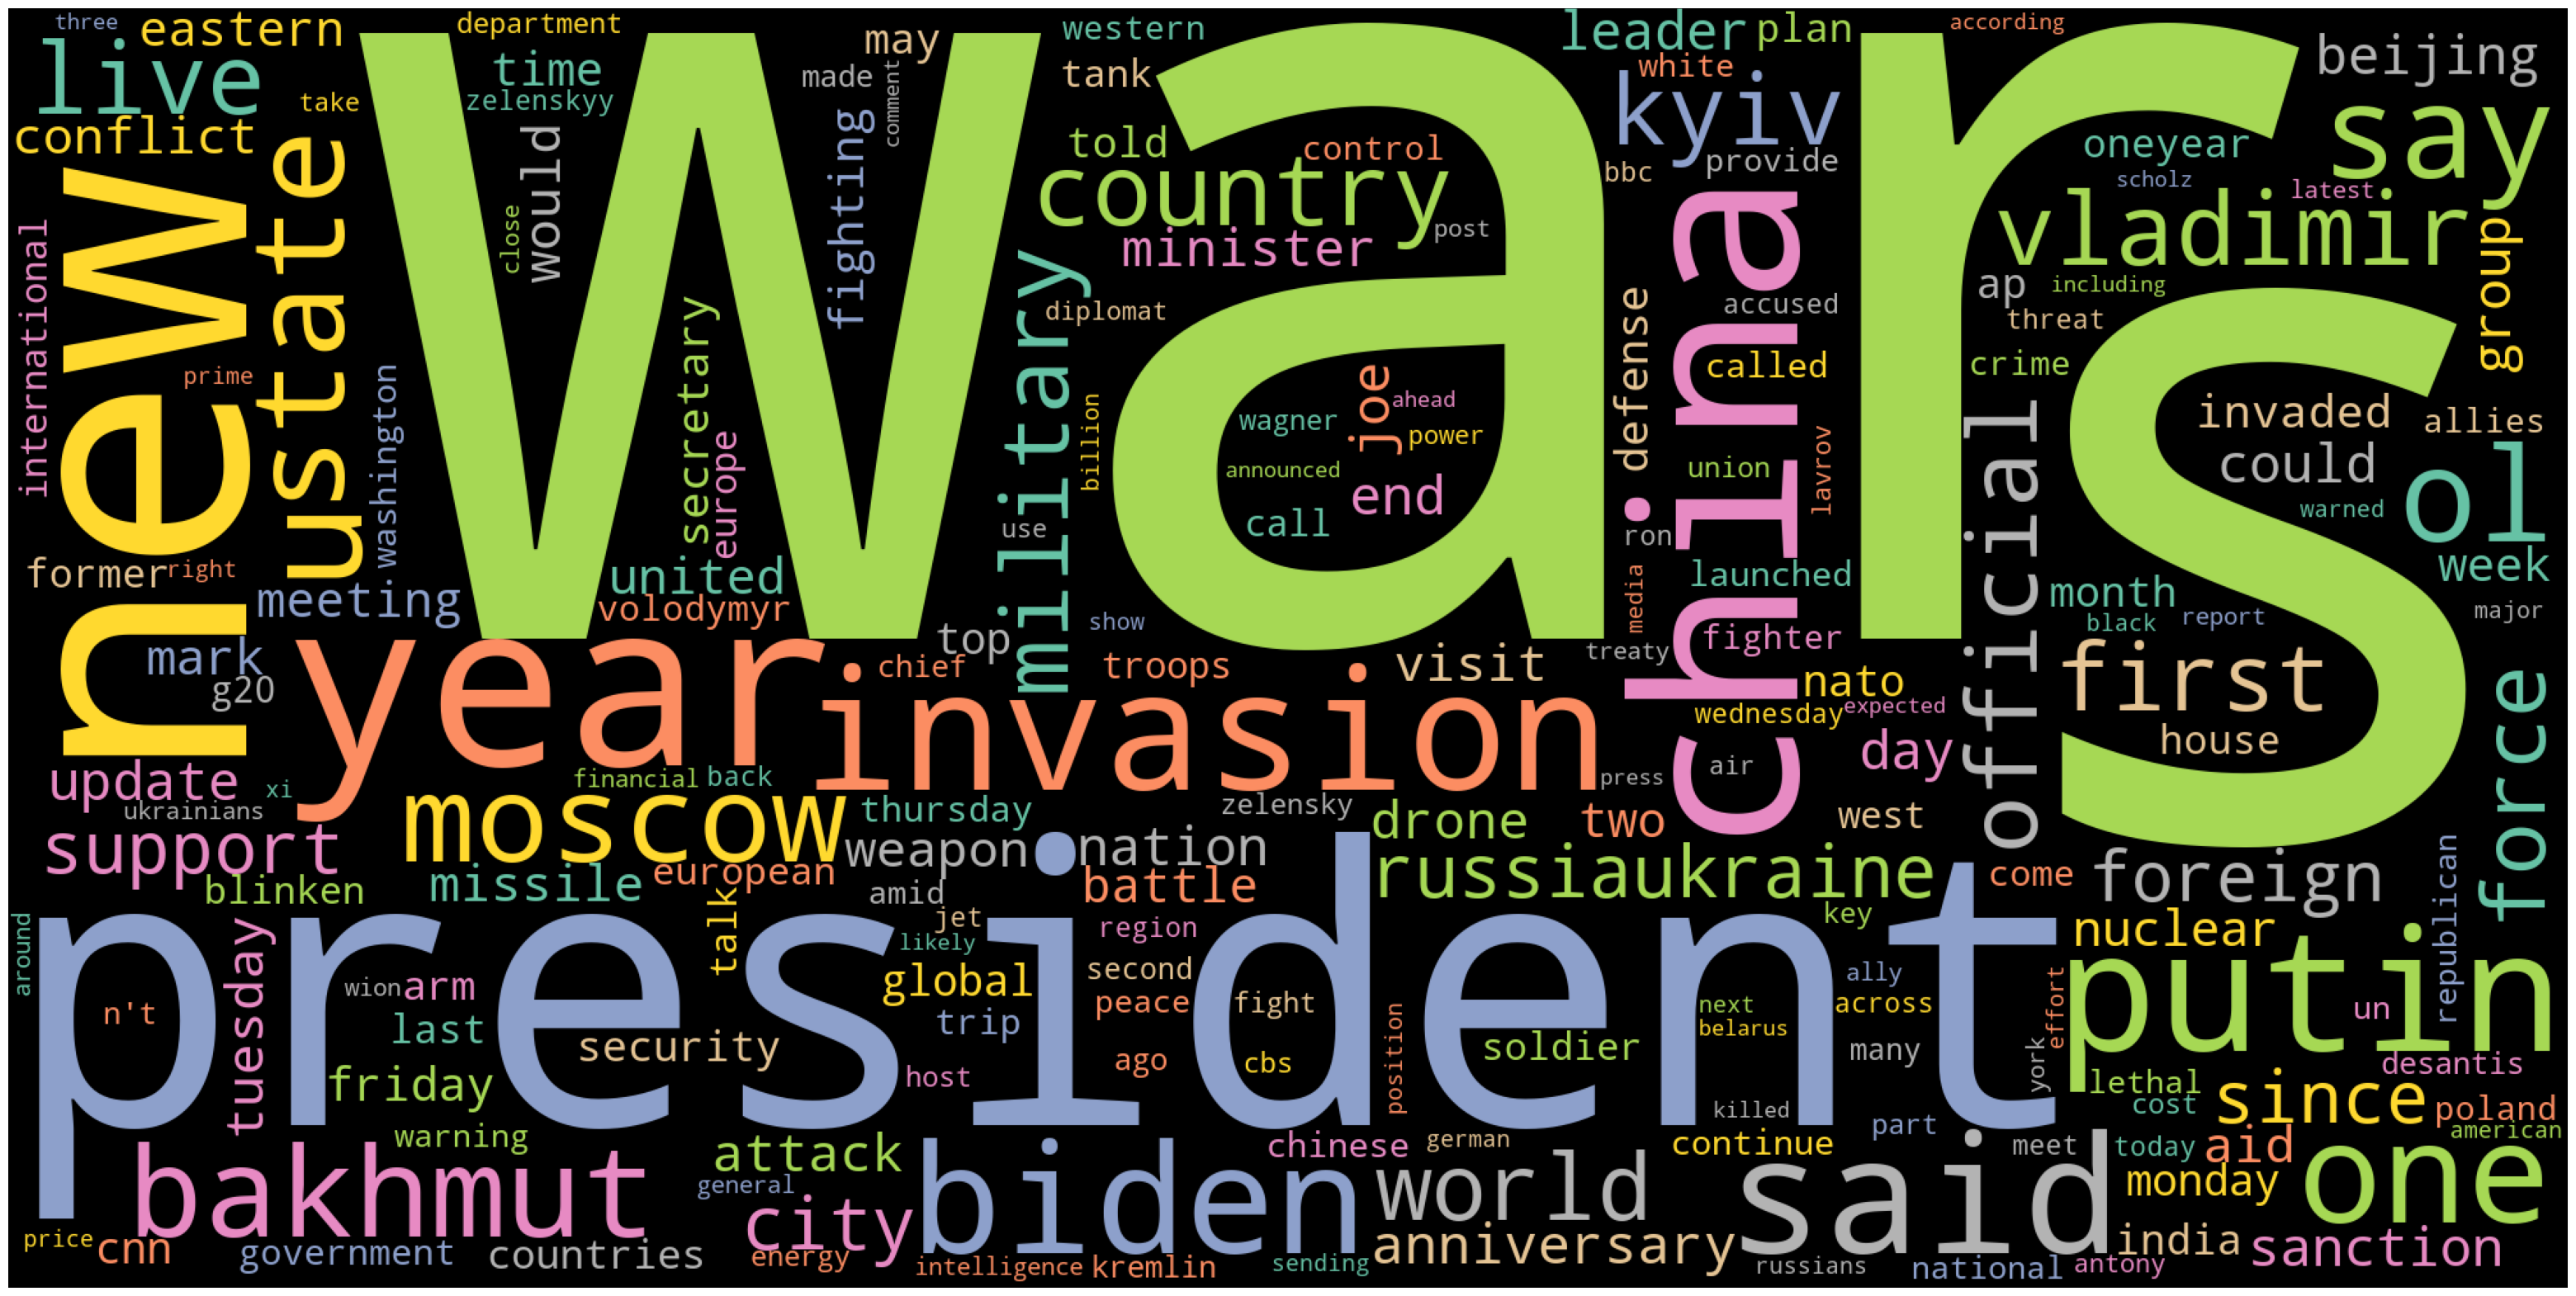

In [69]:
# Wordcloud for Negative Sentiments
### Word Cloud of mostly used word in Tweets

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

my_stop_words = ['russia', 'ukraine', 'people','ukrainian', 'russian','li']

text = " ".join(review for review in news_df_1[news_df_1['score']== 0].Cleaned)
wordcloud = WordCloud(width = 2000, height = 1000, stopwords= my_stop_words, background_color="Black",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)

# Positive Sentiments

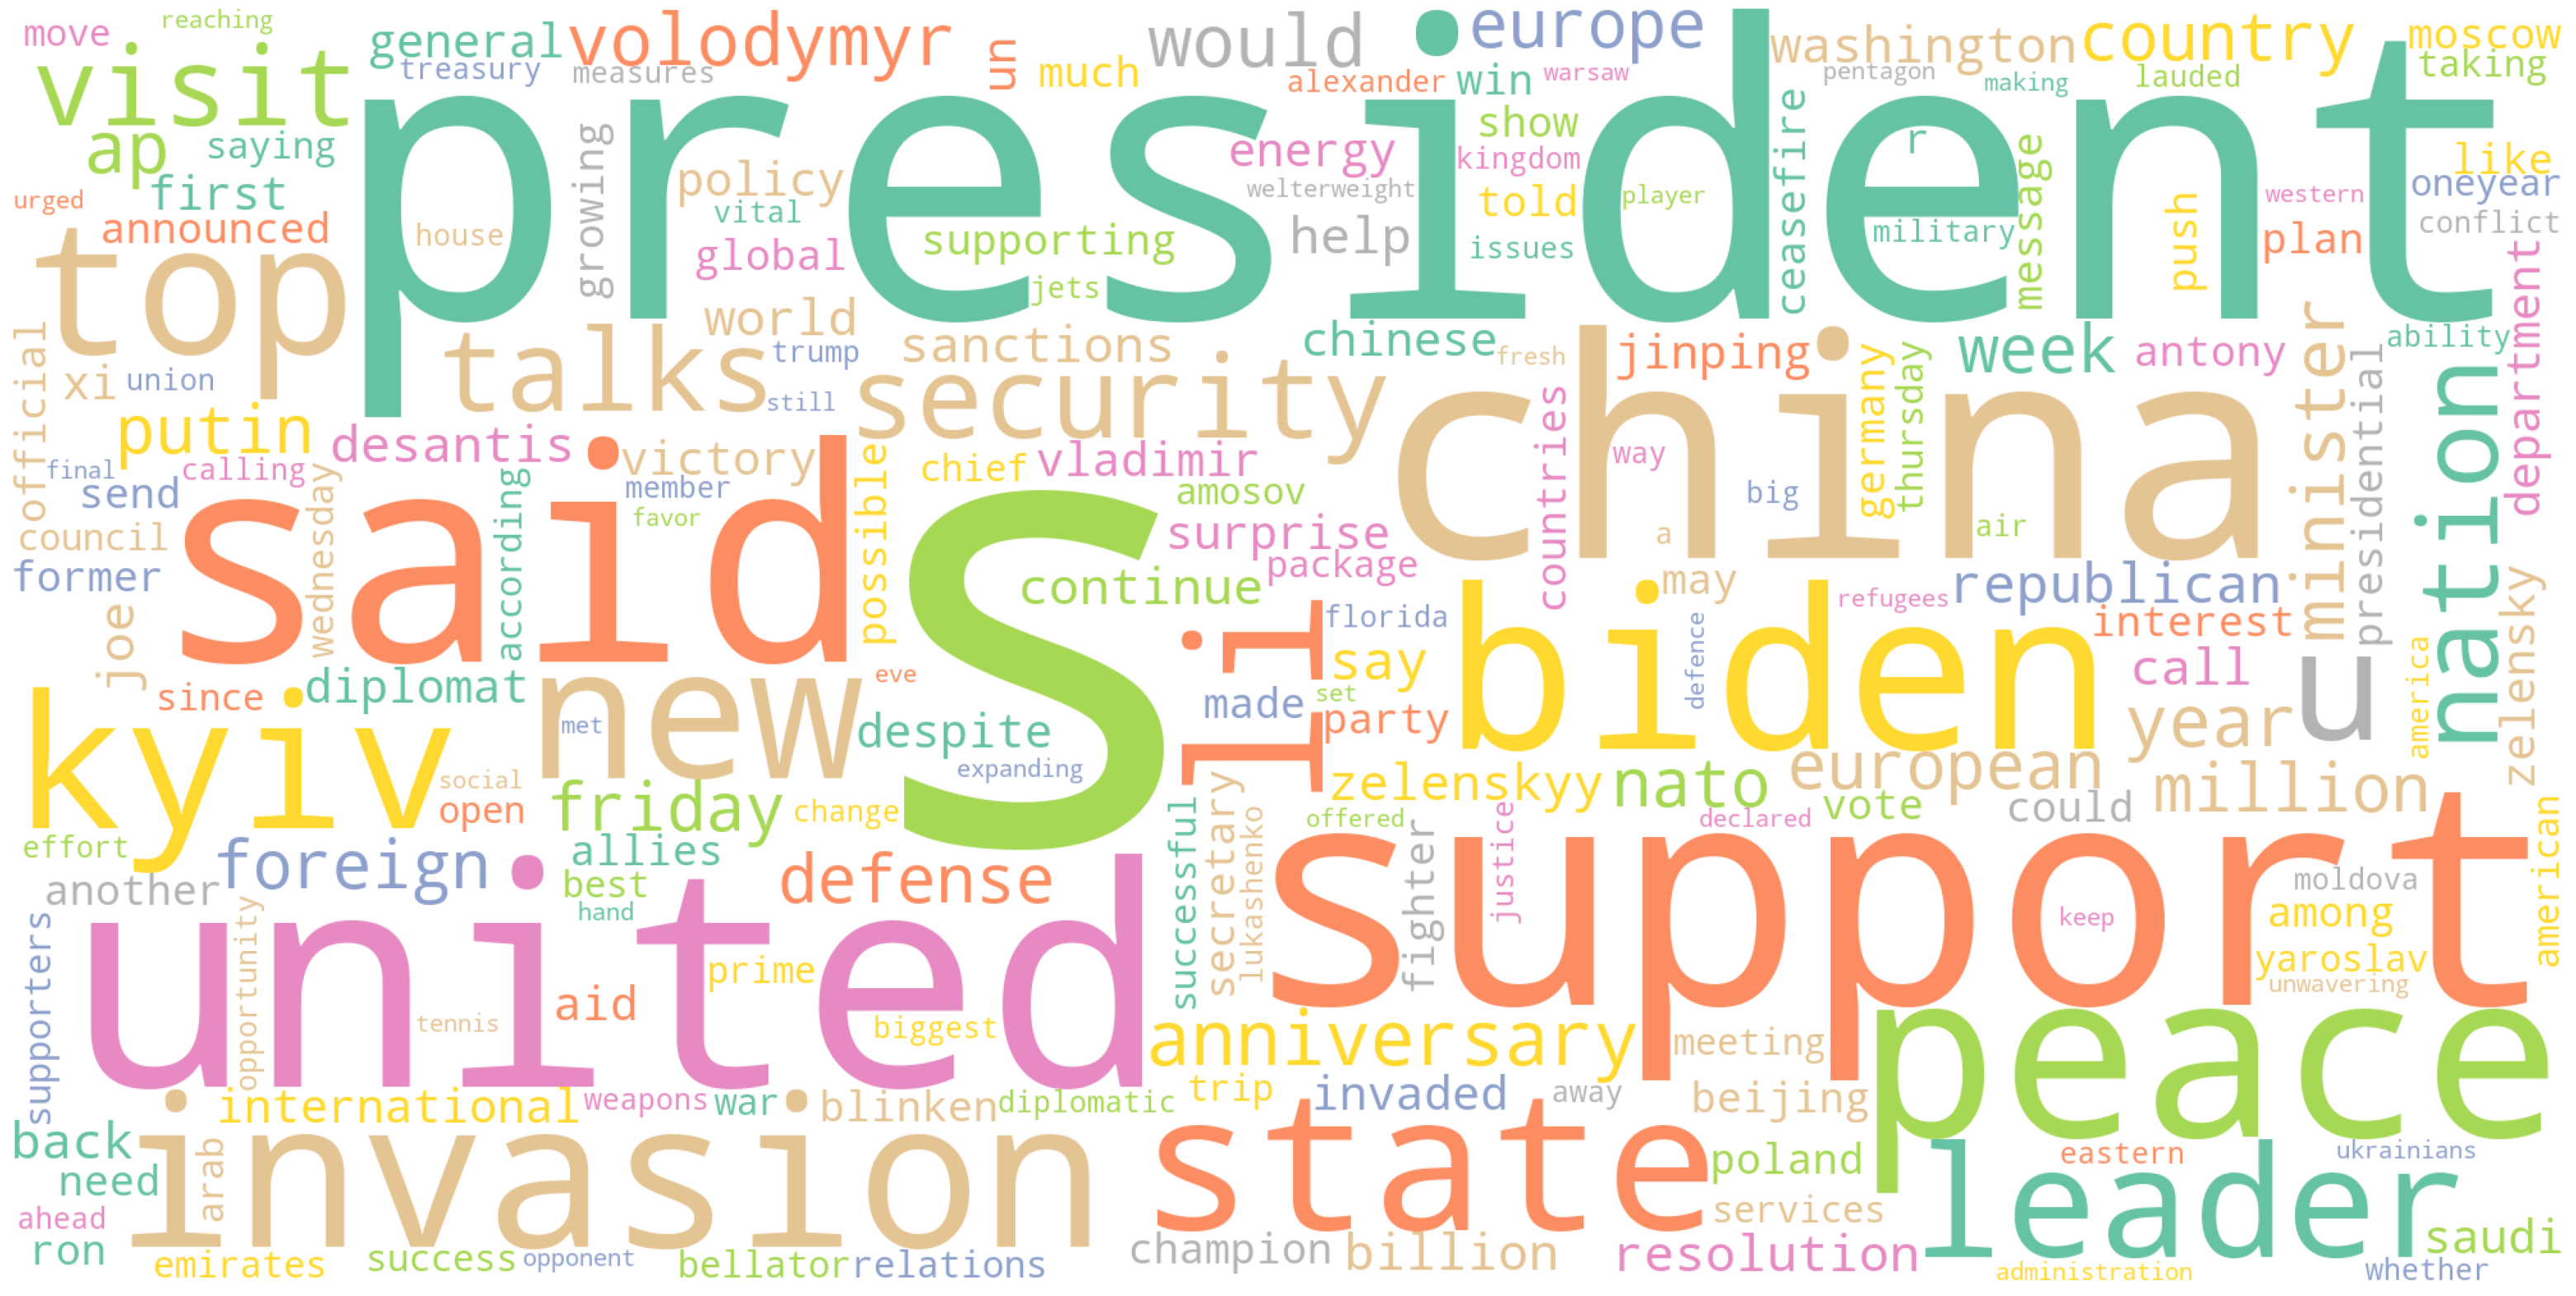

In [70]:
# Wordcloud for Positive Sentiments
### Word Cloud of mostly used word in Tweets
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

my_stop_words = ['russia', 'ukraine', 'people','ukrainian', 'russian']
text = " ".join(review for review in news_df_1[news_df_1['score']== 1].Cleaned)
wordcloud = WordCloud(width = 2000, height = 1000, stopwords=my_stop_words, background_color="white",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = cv.fit_transform(news_df_1['Cleaned'])

# Apply LDA to the document-term matrix
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Print the top words associated with each topic
top_words_dict_news = {}
for i, topic in enumerate(lda.components_):
    topic_words = [cv.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    top_words_dict_news[f"Topic {i+1}"] = topic_words
    print(f"Top words for Topic {i+1}:")
    print(topic_words)
    print('\n')

# Get the topic distribution for each post/tweet
topic_dist_news = lda.transform(doc_term_matrix)

# Add the topic distribution to the original dataset
for i in range(lda.n_components):
    news_df_1[f'topic_{i+1}_dist'] = topic_dist_news[:, i]

# Calculate the mean topic distribution for positive and negative posts/tweets
pos_topic_dist_news = news_df_1[news_df_1['score'] == 1].iloc[:, -lda.n_components:].mean(axis=0)
neg_topic_dist_news = news_df_1[news_df_1['score'] == 0].iloc[:, -lda.n_components:].mean(axis=0)

# # Print the topic distribution for positive and negative posts/tweets
# print("Topic distribution for positive posts/tweets:")
# print(pos_topic_dist_news)
# print("\n")
# print("Topic distribution for negative posts/tweets:")
# print(neg_topic_dist_news)

Top words for Topic 1:
['foreign', 'said', 'russia', 'blinken', 'biden', 'house', 'russian', 'state', 'ukraine', 'president']


Top words for Topic 2:
['eastern', 'forces', 'bakhmut', 'city', 'ukrainian', 'russian', 'war', 'year', 'russia', 'ukraine']


Top words for Topic 3:
['said', 'beijing', 'vladimir', 'president', 'russian', 'war', 'putin', 'china', 'ukraine', 'russia']


Top words for Topic 4:
['russian', 'bakhmut', 'live', 'russiaukraine', 'news', 'ol', 'russia', 'ukraine', 'war', 'li']


Top words for Topic 5:
['support', 'kyiv', 'said', 'anniversary', 'biden', 'invasion', 'war', 'president', 'russia', 'ukraine']




# Topic modeling using Latent Dirichlet Allocation (LDA)

In [50]:
# Create a document-term matrix using CountVectorizer:

my_stop_words = ['russia', 'ukraine', 'people','ukrainian', 'russian']

# max_df=0.95 means that words that appear in more than 95% of the documents will be excluded from the vocabulary, 
# while min_df=2 means that words that appear in fewer than 2 documents will be excluded from the vocabulary. 
# These parameters are used to filter out common words (such as "the" or "and") that are unlikely to be 
# informative for topic modeling or other text analysis tasks.

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= my_stop_words )
doc_term_matrix = vectorizer.fit_transform(news_df_1['Cleaned'])

# Apply LDA to the document-term matrix:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [51]:
# Use the components_ attribute to identify the most important words for each topic:
topic_words = []
for i, topic in enumerate(lda.components_):
    words = [vectorizer.get_feature_names()[j] for j in topic.argsort()[:-11:-1]]
    topic_words.append(words)
    print(f"Top 10 words for topic {i}:")
    print(words)

Top 10 words for topic 0:
['war', 'state', 'blinken', 'group', 'said', 'antony', 'secretary', 'united', 'one', 'country']
Top 10 words for topic 1:
['president', 'invasion', 'year', 'biden', 'war', 'kyiv', 'anniversary', 'one', 'putin', 'since']
Top 10 words for topic 2:
['china', 'war', 'president', 'said', 'putin', 'beijing', 'would', 'could', 'military', 'nuclear']
Top 10 words for topic 3:
['war', 'china', 'said', 'xi', 'us', 'jinping', 'president', 'chinese', 'moscow', 'world']
Top 10 words for topic 4:
['li', 'war', 'ol', 'news', 'live', 'bakhmut', 'russiaukraine', 'putin', 'new', 'china']


In [52]:
# prints the top 10 words for each topic based on the word distribution in the lda.components_ array.
doc_topic_dist = lda.transform(doc_term_matrix)

# Use the topic distribution to identify the most relevant topics for each document
for i in range(doc_topic_dist.shape[0]):
    print(f"Document {i} most likely topic: {np.argmax(doc_topic_dist[i])}")

Document 0 most likely topic: 2
Document 1 most likely topic: 4
Document 2 most likely topic: 3
Document 3 most likely topic: 4
Document 4 most likely topic: 0
Document 5 most likely topic: 4
Document 6 most likely topic: 2
Document 7 most likely topic: 1
Document 8 most likely topic: 3
Document 9 most likely topic: 0
Document 10 most likely topic: 4
Document 11 most likely topic: 1
Document 12 most likely topic: 1
Document 13 most likely topic: 4
Document 14 most likely topic: 2
Document 15 most likely topic: 3
Document 16 most likely topic: 1
Document 17 most likely topic: 2
Document 18 most likely topic: 3
Document 19 most likely topic: 1
Document 20 most likely topic: 3
Document 21 most likely topic: 3
Document 22 most likely topic: 0
Document 23 most likely topic: 2
Document 24 most likely topic: 2
Document 25 most likely topic: 4
Document 26 most likely topic: 4
Document 27 most likely topic: 3
Document 28 most likely topic: 4
Document 29 most likely topic: 4
Document 30 most lik

In [53]:
# Use perplexity() and loglikelihood() to evaluate the quality of the model fit:
print(f"Perplexity: {lda.perplexity(doc_term_matrix)}")
print(f"Log-likelihood: {lda.score(doc_term_matrix)}")

Perplexity: 1418.1354481315248
Log-likelihood: -127071.78988603222


In [54]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Visualize the results
vis = pyLDAvis.sklearn.prepare(lda, doc_term_matrix, vectorizer)
pyLDAvis.display(vis)

In [56]:
# Create a document-term matrix using CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = cv.fit_transform(elon_reply_df_1['cleaned'])

# Apply LDA to the document-term matrix
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)


# Print the top words associated with each topic
top_words_dict_tw = {}
for i, topic in enumerate(lda.components_):
    topic_words = [cv.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    top_words_dict_tw[f"Topic {i+1}"] = topic_words
    print(f"Top words for Topic {i+1}:")
    print(topic_words)
    print('\n')

# Get the topic distribution for each post/tweet
topic_dist_tw = lda.transform(doc_term_matrix)

# Add the topic distribution to the original dataset
for i in range(lda.n_components):
    elon_reply_df_1[f'topic_{i+1}_dist'] = topic_dist_tw[:, i]

# Calculate the mean topic distribution for positive and negative posts/tweets
pos_topic_dist_tw = elon_reply_df_1[elon_reply_df_1['score'] == 1].iloc[:, -lda.n_components:].mean(axis=0)
neg_topic_dist_tw = elon_reply_df_1[elon_reply_df_1['score'] == 0].iloc[:, -lda.n_components:].mean(axis=0)

# # Print the topic distribution for positive and negative posts/tweets
# print("Topic distribution for positive posts/tweets:")
# print(pos_topic_dist_tw)
# print("\n")
# print("Topic distribution for negative posts/tweets:")
# print(neg_topic_dist_tw)

Top words for Topic 1:
['referendum', 'live', 'let', 'russian', 'want', 'crimea', 'vote', 'ukraine', 'people', 'russia']


Top words for Topic 2:
['na', 'wtf', 'time', 'like', 'propaganda', 'nuclear', 'world', 'elon', 'russian', 'putin']


Top words for Topic 3:
['ілон', 'что', 'маск', 'це', 'за', 'ты', 'що', 'на', 'ти', 'не']


Top words for Topic 4:
['stop', 'ukrainian', 'ukrainians', 'russian', 'putin', 'people', 'peace', 'war', 'russia', 'ukraine']


Top words for Topic 5:
['people', 'stupid', 'twitter', 'stop', 'know', 'like', 'tesla', 'fuck', 'musk', 'elon']




In [40]:
# Create a document-term matrix using CountVectorizer:
my_stop_words = ['russia', 'ukraine', 'people']
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=my_stop_words)
doc_term_matrix = vectorizer.fit_transform(elon_reply_df_1['cleaned'])

# Apply LDA to the document-term matrix:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [41]:
# Use the components_ attribute to identify the most important words for each topic:
topic_words = []
for i, topic in enumerate(lda.components_):
    words = [vectorizer.get_feature_names()[j] for j in topic.argsort()[:-11:-1]]
    topic_words.append(words)
    print(f"Top 10 words for topic {i}:")
    print(words)

Top 10 words for topic 0:
['let', 'elon', 'want', 'tesla', 'give', 'decide', 'live', 'like', 'go', 'try']
Top 10 words for topic 1:
['crimea', 'russian', 'vote', 'would', 'russians', 'part', 'ukrainian', 'ukrainians', 'want', 'referendum']
Top 10 words for topic 2:
['elon', 'peace', 'war', 'putin', 'world', 'one', 'good', 'like', 'know', 'would']
Top 10 words for topic 3:
['не', 'ти', 'на', 'що', 'ты', 'за', 'це', 'маск', 'что', 'ілон']
Top 10 words for topic 4:
['elon', 'stop', 'fuck', 'war', 'putin', 'nuclear', 'go', 'better', 'know', 'man']


In [42]:
# prints the top 10 words for each topic based on the word distribution in the lda.components_ array.
doc_topic_dist = lda.transform(doc_term_matrix)

# Use the topic distribution to identify the most relevant topics for each document
for i in range(doc_topic_dist.shape[0]):
    print(f"Document {i} most likely topic: {np.argmax(doc_topic_dist[i])}")

Document 0 most likely topic: 0
Document 1 most likely topic: 4
Document 2 most likely topic: 2
Document 3 most likely topic: 2
Document 4 most likely topic: 2
Document 5 most likely topic: 0
Document 6 most likely topic: 2
Document 7 most likely topic: 1
Document 8 most likely topic: 0
Document 9 most likely topic: 1
Document 10 most likely topic: 2
Document 11 most likely topic: 0
Document 12 most likely topic: 1
Document 13 most likely topic: 2
Document 14 most likely topic: 1
Document 15 most likely topic: 2
Document 16 most likely topic: 0
Document 17 most likely topic: 0
Document 18 most likely topic: 4
Document 19 most likely topic: 4
Document 20 most likely topic: 2
Document 21 most likely topic: 0
Document 22 most likely topic: 1
Document 23 most likely topic: 1
Document 24 most likely topic: 2
Document 25 most likely topic: 2
Document 26 most likely topic: 2
Document 27 most likely topic: 0
Document 28 most likely topic: 2
Document 29 most likely topic: 2
Document 30 most lik

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
# Use perplexity() and loglikelihood() to evaluate the quality of the model fit:
print(f"Perplexity: {lda.perplexity(doc_term_matrix)}")
print(f"Log-likelihood: {lda.score(doc_term_matrix)}")

Perplexity: 2881.6293951874027
Log-likelihood: -24086556.80094572


In [44]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Visualize the results
vis = pyLDAvis.sklearn.prepare(lda, doc_term_matrix, vectorizer)
pyLDAvis.display(vis)

# Part 4

## Accracy and F1 scores

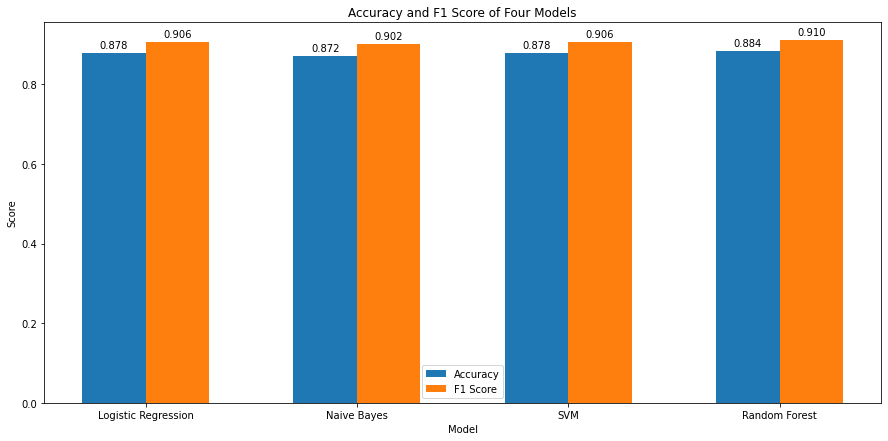

In [ ]:
model_names = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest']
accuracy_scores = [LOG_acc, test_accuracy, SVM_acc, RF_acc]
f1_scores = [LOG_f1, test_f1, SVM_f1, RF_f1]

bar_width = 0.3
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the bar chart for accuracy scores
bar1 = ax.bar(np.arange(len(model_names)), accuracy_scores, bar_width, label='Accuracy')

# Plot the bar chart for F1 scores next to the accuracy chart
bar2 = ax.bar(np.arange(len(model_names))+bar_width, f1_scores, bar_width, label='F1 Score')

# Add the model names to the x-axis ticks
plt.xticks(np.arange(len(model_names))+bar_width/2, model_names)

# Add axis labels and a title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score of Four Models')

# Add a legend and show the plot
plt.legend()

# Add error bars to the plot
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

# Show the plot
plt.show()

## Sentiment Trends Over Time

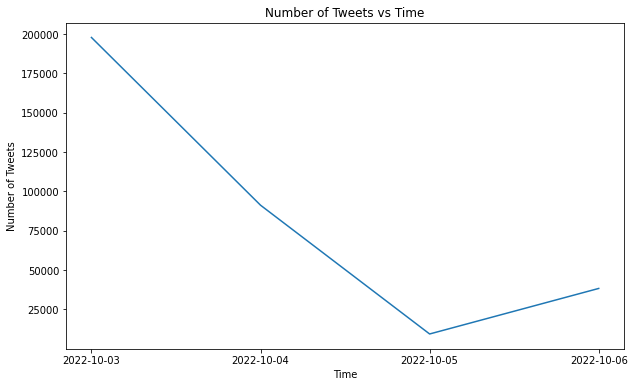

In [ ]:
from datetime import datetime
# add sentiments score to the df
sentiment_time = elon_reply_df
sentiment_time['sentiment'] = y_pred_RF_elon
# Convert date column to datetime format
sentiment_time['created_at'] = pd.to_datetime(sentiment_time['created_at'])
# Extract date part
sentiment_time['created_at'] = sentiment_time['created_at'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
# number of tweets for each date
tweet_counts = sentiment_time['created_at'].value_counts().sort_index()
# Plot the tweet counts vs time
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tweet_counts.index, tweet_counts.values)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Tweets')
ax.set_title('Number of Tweets vs Time')
plt.show()

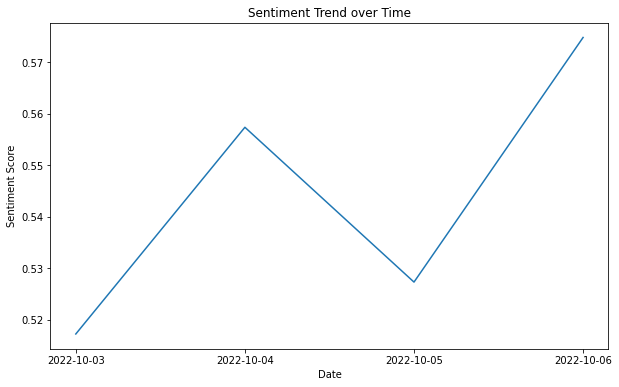

In [ ]:
# Group by date and calculate mean sentiment score
fig= plt.subplots(figsize=(10,6))
df_grouped = sentiment_time.groupby('created_at')['sentiment'].mean().reset_index()
# Plot sentiment trend over time
plt.plot(df_grouped['created_at'], df_grouped['sentiment'])
plt.title('Sentiment Trend over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

## Average Length and words counts for Twitter and News

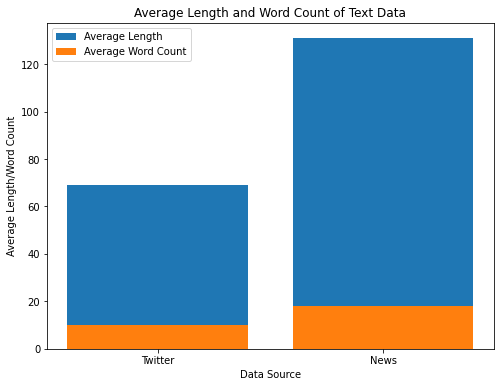

In [ ]:
# Plot the average length and average word counts for Twitter and news
plt.figure(figsize=(8,6))
plt.bar(['Twitter', 'News'], [round(np.mean(elon_reply_df_1['text_len'])), np.mean(news_df_1['text_len'])], label='Average Length')
plt.bar(['Twitter', 'News'], [round(np.mean(elon_reply_df_1['text_word_count'])), np.mean(news_df_1['text_word_count'])], label='Average Word Count')
plt.title('Average Length and Word Count of Text Data')
plt.xlabel('Data Source')
plt.ylabel('Average Length/Word Count')
plt.legend()
plt.show()

## Topic and Sentiment Dsitribution

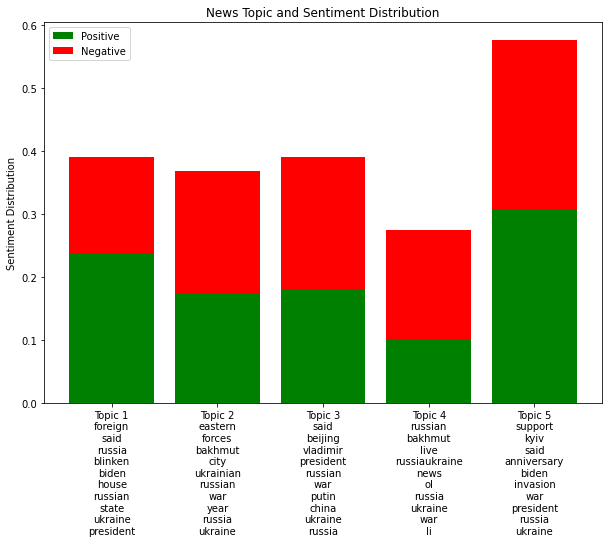

In [ ]:
# Define sentiment labels
sentiments = ['Positive', 'Negative']

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(10,7))
x_pos = np.arange(len(top_words_dict_news))
ax.bar(x_pos, pos_topic_dist_news, label='Positive', color='green')
ax.bar(x_pos, neg_topic_dist_news, bottom=pos_topic_dist_news, label='Negative', color='red')

labels = [f'Topic {i+1}\n' + '\n'.join(top_words_dict_news[f'Topic {i+1}']) for i in range(len(top_words_dict_news))]
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

# Add labels and legend
ax.set_ylabel('Sentiment Distribution')
ax.set_title('News Topic and Sentiment Distribution')
ax.legend()

plt.show()

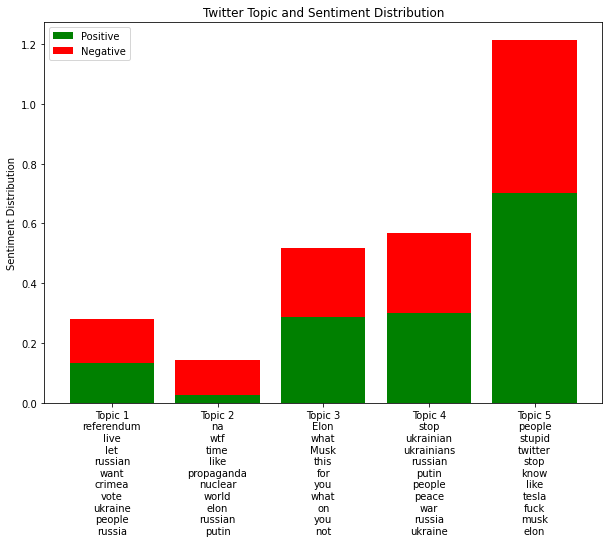

In [ ]:
# translate topic 3 into English
top_words_dict_tw['Topic 3'] = ['Elon', 'what', 'Musk', 'this', 'for', 'you', 'what', 'on', 'you', 'not']
# Define sentiment labels
sentiments = ['Positive', 'Negative']

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(10,7))
x_pos = np.arange(len(top_words_dict_tw))
ax.bar(x_pos, pos_topic_dist_tw, label='Positive', color='green')
ax.bar(x_pos, neg_topic_dist_tw, bottom=pos_topic_dist_tw, label='Negative', color='red')

labels = [f'Topic {i+1}\n' + '\n'.join(top_words_dict_tw[f'Topic {i+1}']) for i in range(len(top_words_dict_tw))]
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

# Add labels and legend
ax.set_ylabel('Sentiment Distribution')
ax.set_title('Twitter Topic and Sentiment Distribution')
ax.legend()

plt.show()